jupyter nbconvert --to slides --post serve PresNotebook

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
from imblearn.under_sampling import RandomUnderSampler
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/HAM10000_metadata.csv'
meta_data = pd.read_csv(file, ',')
file = '/Users/cameronsellers/code/cecyprice/skin_lesion_detection/dataset/hmnist_8_8_RGB.csv'
image_data = pd.read_csv(file, ',')
from IPython.display import Image

In [11]:
def balance(data):
    return data
def augment(data):
    return data

def balance2(data, under_sample_size):
        ## isolate nv rows
        data_nv = data[data['dx'] == 'nv']
        # define scaling parameters 
        sample_size = under_sample_size
        scaling = under_sample_size / data_nv.shape[0] 
        # stratified sampling 
        rus = RandomUnderSampler(sampling_strategy={'lower extremity' : int(1224*scaling),
                                                    'trunk' : int(1153*scaling), 
                                                    'back' : int(1058*scaling),
                                                    'abdomen' : int(719*scaling), 
                                                    'upper extremity' : int(504*scaling) ,
                                                    'foot' : int(209*scaling), 
                                                    'unknown' : int(175*scaling),
                                                    'chest' : int(112*scaling),
                                                    'face' : int(61*scaling),
                                                    'neck' : int(60*scaling), 
                                                    'genital' : int(43*scaling), 
                                                    'hand' : int(39*scaling), 
                                                    'scalp' : int(24*scaling), 
                                                    'ear' : int(19*scaling),
                                                    'acral' : int(3*scaling)+1
                                                   }, 
                                   random_state=None,
                                   replacement=False,
                                )
        ## fit strtaified sampling model 
        n_x, n_y = rus.fit_resample(data_nv, data_nv['localization'])
        ## delete nv rows from original dataset
        no_nv_data = data[data.dx != 'nv']
        data = pd.concat([n_x, no_nv_data], axis=0)
        return data
    
def data_augmentation(df, image_size = 'resized'):
    print(df.shape)
    df = df.reset_index(drop=True)
    ## Define random image modifications
    aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

    if image_size == 'resized':
        target_images = 'images_resized'
        input_size = (75,100,3)
        df = df.drop(['images'], axis =1)
        new_df = df.copy()
        new_df = new_df.drop(['images_resized'], axis=1)


    elif image_size == 'full_size':
        target_images = 'images'
        input_size = (450,600,3)
        df = df.drop(['images_resized'], axis =1)
        new_df = df.copy()
        new_df = new_df.drop(['images'], axis=1)

    ## Create np.array of augmented images from original images dataframe. Reshape to feed into dataGen
    images_array = np.array([i.reshape(input_size) for i in df[target_images].values])

    #construct the actual Python generator, iterate over imagegenerator object
    dataGen = aug.flow(images_array, batch_size = images_array.shape[0])
    for i in dataGen:
        break

    ## flatten i before concatenating it into new dataframe copy
    i = i.reshape(len(df), input_size[0]*input_size[1]*input_size[2])

    ## turn i from array into list so it can be converted into pd
    im_list = []
    for im in i:
        im_list.append(im)

    # convert i into the pandas i_df
    i_df = pd.DataFrame({target_images: im_list})

    ## concatenate new_df numpy array and new augmented image array
    com_new_df = pd.concat((new_df, i_df), axis = 1)

    ## vertically concatenate new dataframes

    frames = [df, com_new_df]
    df = pd.concat(frames)
    df.reset_index(drop=True, inplace=True)
    print(df.shape)
    return df

def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [5]:
repetition_counts = meta_data.groupby('lesion_id').agg({'image_id': 'count', 'dx_type': 'count', 'age': 'mean', 'sex': 'count', 'localization': 'count', 'dx': 'first', }).reset_index()
repetition_counts.columns = ['lesion_id', 'image_count', 'count_dx_type', 'mean_age', 'count_sex', 'count_location', 'dx']

# Team 2 - SKIN LESION DETECTION
---

### Dataset Overview
---

The HAM10000 ("Human Against Machine with 10000 training images") dataset is composed of:

- 10015 images of labelled skin lesions
- Patient meta-data.

### Metadata
---

Our metadata contains information for each patient:

- 'dx' - the type of skin lesion
- 'dx-type' - how the lesion was discovered
- Patient sex
- Patient age
- Lesion location

In [3]:
meta_data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Project Aims 
---

> To train a model to predict the type of skin-lesion, 'dx' from an image 


> To create an app that can take a skin lesion image and output a prediction

# AGENDA
---

1. Data Retrieval and Exploration
    - Data retrieval
    - Visualisation of the distribution of age, sex, localization
    - Distribution of the target variable
2. Data Preparation
    - Cleaning
    - Encoding
    - Merging datasets
3. Data Balancing and Augmentation
    - Balancing
    - Augmentation    
4. Model construction
    - Baseline model
    - VGG16, Resnet50, Densenet models
5. Evaluation 
    - Model performance and evaluation
    - Confusion matrix
6. Streamlit app
    - Streamlit interface
7. Limitations & Future perspectives
    - Limitations of the model performance
    - Team performance

# DATA RETRIEVAL & EXPLORATION

## Dataset Overview
---

The HAM10000 ("Human Against Machine with 10000 training images") dataset is composed of:

- 10015 images of labelled skin lesions
- Patient meta-data.

## Image Dataset

In [ ]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))

# Sample images
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=500)

## Metadata

In [ ]:
plt.style.use('seaborn-dark')

In [ ]:
plt.figure(figsize=(10, 3))
meta_data['localization'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Localization of the skin lesion')

In [ ]:
plt.figure(figsize=(4, 3))
meta_data['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of male and female patients')

In [ ]:
plt.figure(figsize=(10, 3))
sns.countplot(meta_data['age'])
plt.title('Distribution of the age of patients')

In [ ]:
plt.figure(figsize=(6, 3))
sns.countplot(meta_data['dx'].sort_values(ascending=False))

# DATA PREPARATION 

## Missing values and Duplicates

The dataset contains a few missing values and duplicates that can be easily filled or removed.

In [ ]:
# fill 67 missing age values with mean
meta_data['age'].fillna((meta_data['age'].mean()), inplace = True)

In [ ]:
# drop duplicates as duplicates evenly distributed across lesion types 
meta_data = meta_data.drop_duplicates(subset=['lesion_id'], keep = 'first')

## Feature Encoding 
--- 

**Pipeline Structure:**

- OneHotEncoding of categorical features: location, sex, dx_type
- RobustScaler of continuous features: age 
- Custom scaling of image pixels.

# BALANCING AND AUGMENTATION

There are seven types of skin lesion in the HAM10000 set:

---
1. Melanocytic nevi - 'nv'
2. Melanoma - 'mel'
3. Benign keratosis-like lesions - 'bkl'
4. Basal cell carcinoma - 'bcc'
5. Actinic keratoses - 'akiec'
6. Vascular lesions - 'vasc'
7. Dermatofibroma - 'df'

--- 
Representations of each lesion were unbalanced

> 'nv' lesions are overrepresented 

> 'vasc' and 'df' lesions are underrepresented

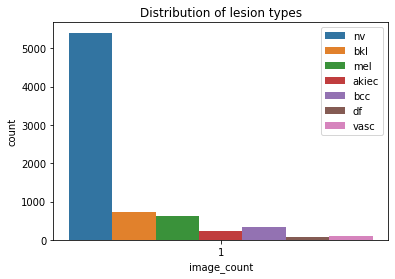

In [16]:
chart = sns.countplot(x="image_count", hue="dx", data=(repetition_counts[['image_count', 'dx', 'lesion_id']]))
plt.legend(loc='upper right')
plt.title("Distribution of lesion types")
hide_code_in_slideshow()

We can improve the set by:

> Undersampling 'nv'

> Augmenting the whole dataset to improve training on 'vasc' and 'df'

In [7]:
meta_data = balance2(meta_data, 1000)
meta_data2 = meta_data.copy() 
frames = [meta_data, meta_data2]
meta_data = pd.concat(frames)

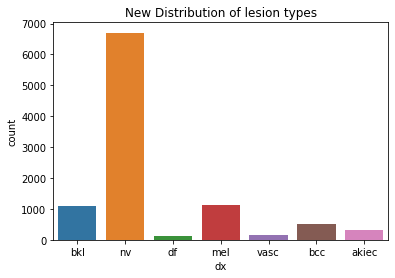

In [18]:
meta_data = balance(meta_data)
meta_data = augment(meta_data)
sns.countplot(meta_data['dx'])
plt.title("New Distribution of lesion types")
hide_code_in_slideshow()

# MODEL CONSTRUCTION
---

Show images of the VGG16, RESNET50 and DENSENET model structures (layers)

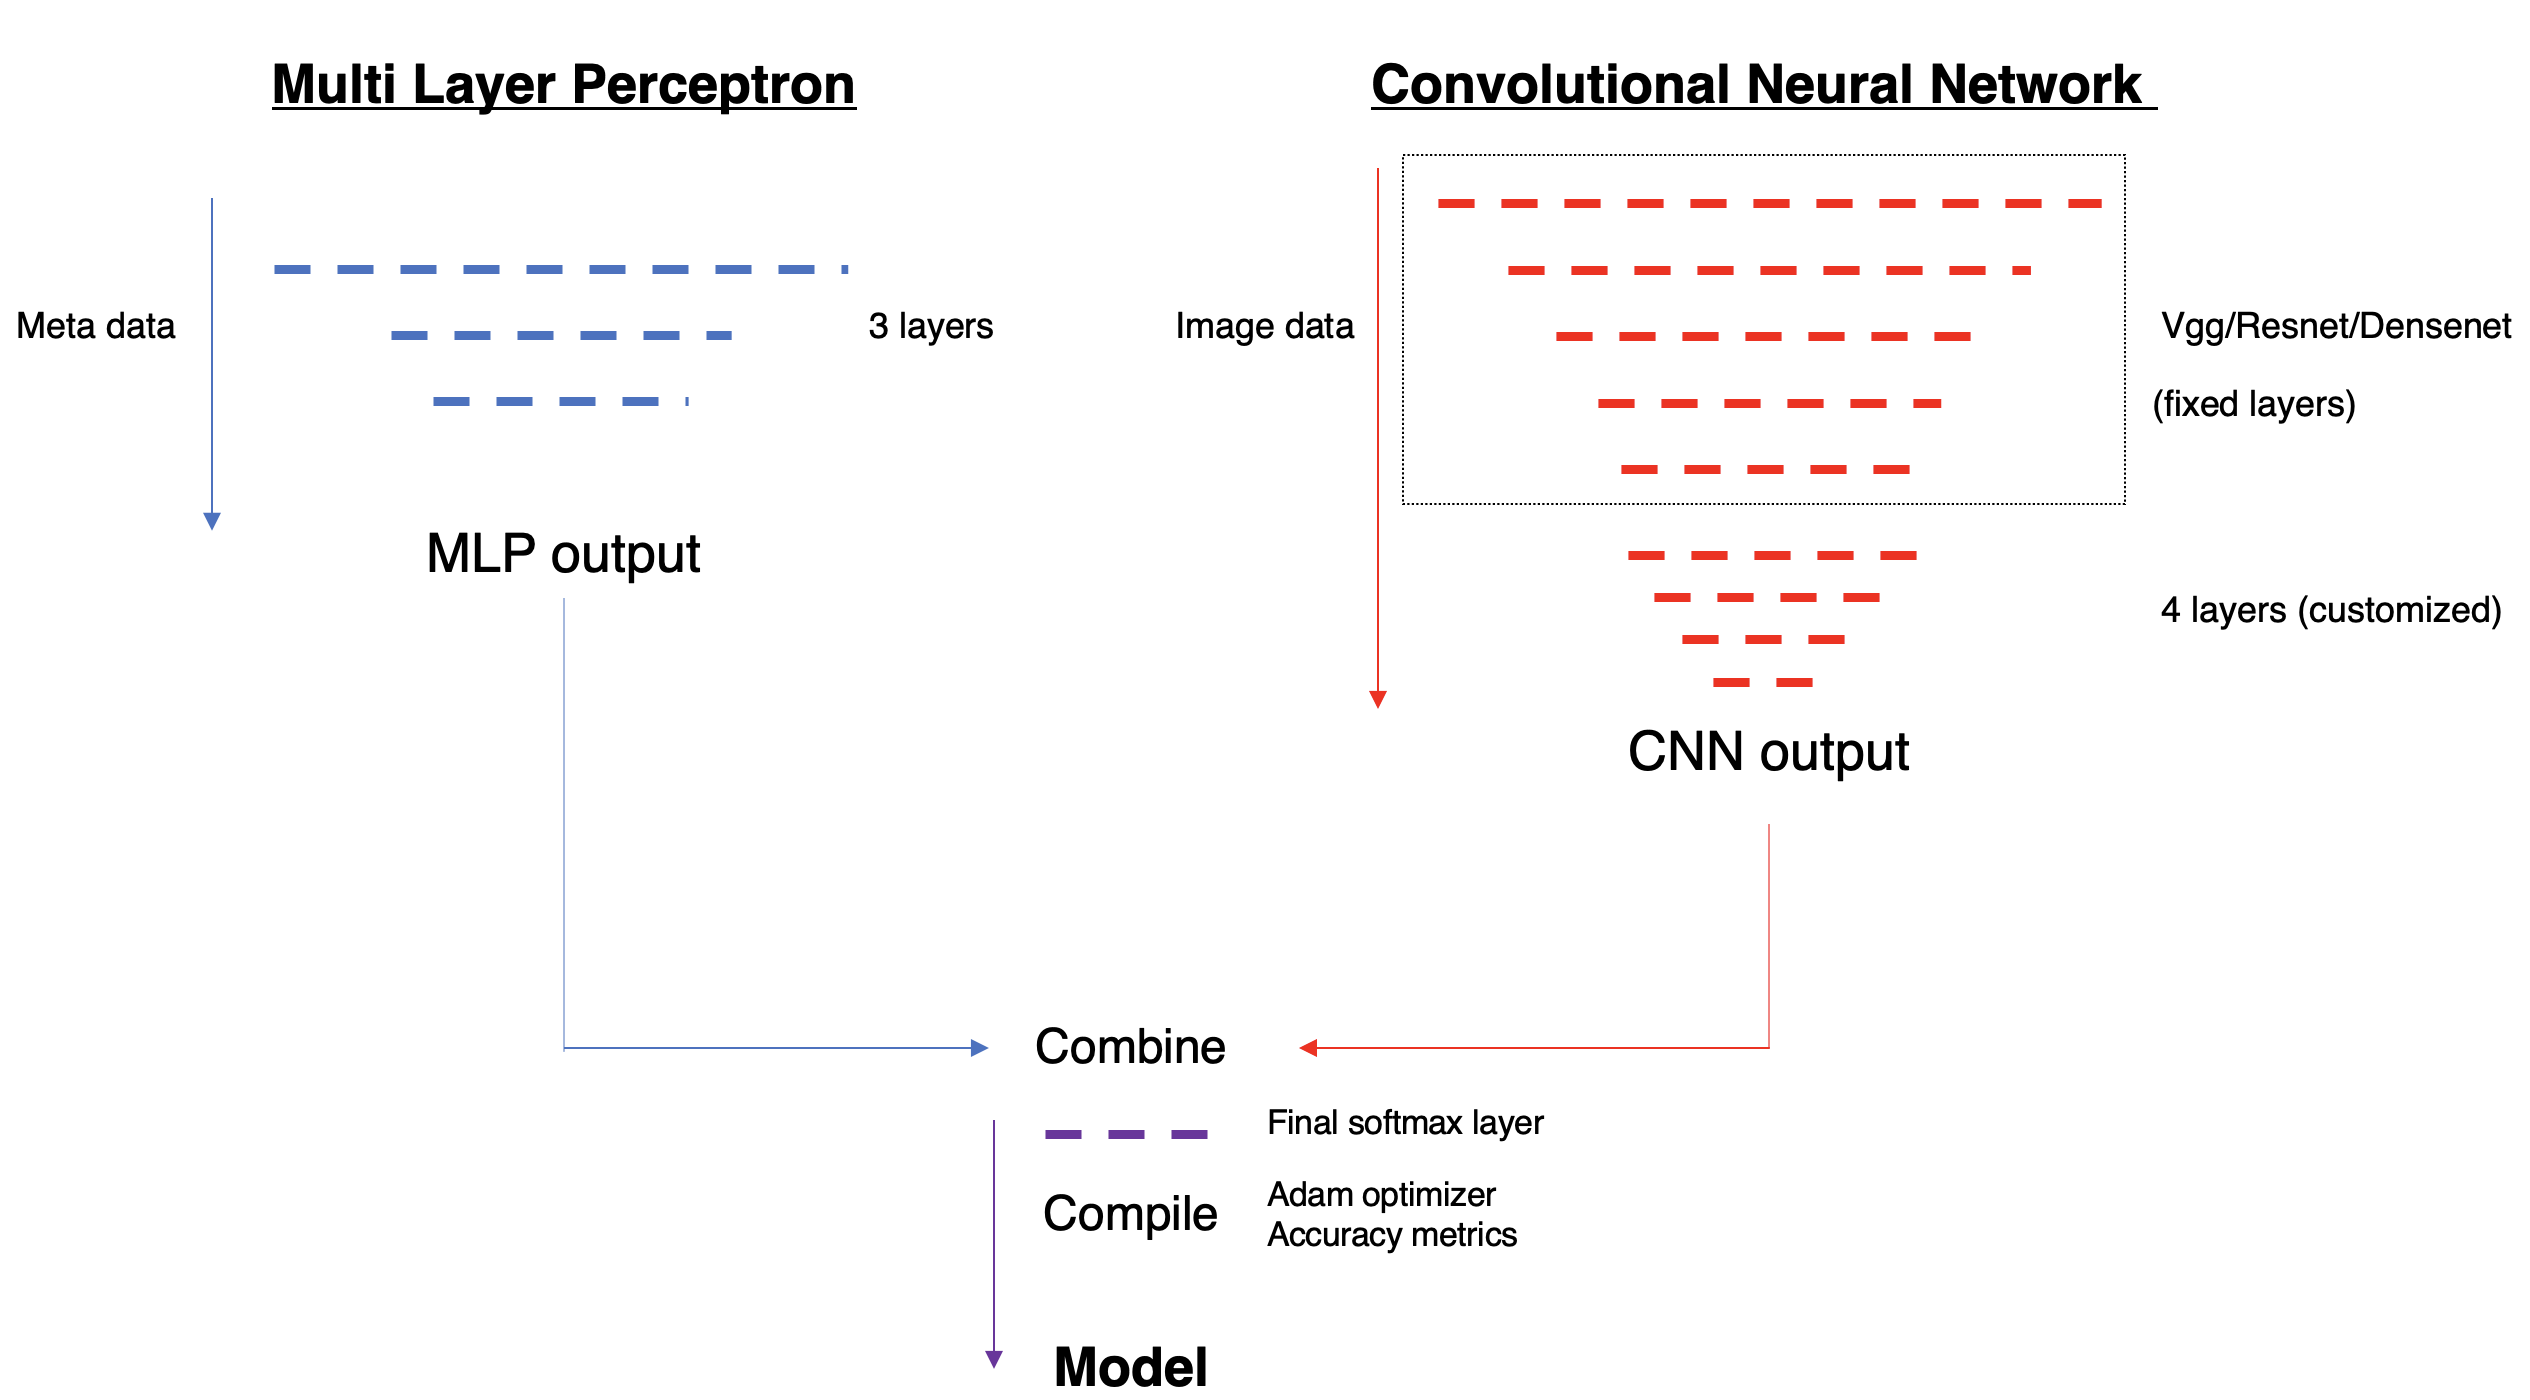

In [14]:
Image("LWD.png")

In [ ]:
# display the layers of our model (relationship of iterable - non-iterable layers)
model.summary()

# EVALUATION 
---

### Accuracy and Top3 Class Accuracy Scores


### Confusion Matrix

# STREAMLIT 
---

We created an app on streamlit that will 'diagnose' lesions. 

**Do not use our app to (reliably) check your moles**

# LIMITATIONS AND FUTURE PERSPECTIVES
---

**Limitations of the Model Performance**

- Size of the dataset
- Hyperparameter tuning (that never came to be) 
- Full sized images

**Team Performance**

- Train a model sooner!

# Thank you